In [1]:
from agent import Agent
from policy import Policy
from action import Action
from state import State
from memory import Memory
from qNetwork import QNetwork

import os
import torch
import gymnasium as gym
from torch import nn

In [2]:
# Policy data
START_EPSILON = 1
DECAY = 0.996
FINAL_EPSILON = 0.01

# Memory data
MEMORY_SIZE = 30_000

# Training settings
NUMBER_OF_ITERATIONS = 1_00
DISCOUNT_GAMMA = 0.99
MEMORY_BATCH_SIZE_PER_TRAINING_STEP = 64
NEURAL_NETWORK_BATCH_SIZE = 4
STEP_LIMIT_PER_RUN = 200_000_000_000_000_000_000
LOSS_FUNCTION = nn.MSELoss()
OPTIMIZER = torch.optim.Adam
NUMBER_OF_EPISODES_PER_ITERATION = 1
NN_SEED = 42

In [3]:
def train(agent):
    env = gym.make("LunarLander-v2")
    agent.train(
        environment=env,
        n_iterations=NUMBER_OF_ITERATIONS,
        gamma=DISCOUNT_GAMMA,
        memory_batch_size=MEMORY_BATCH_SIZE_PER_TRAINING_STEP,
        batch_size=NEURAL_NETWORK_BATCH_SIZE,
        steps_limit=STEP_LIMIT_PER_RUN,
        loss_fn=LOSS_FUNCTION,
        optimizer=OPTIMIZER,
        n_episodes=NUMBER_OF_EPISODES_PER_ITERATION,
        seed=NN_SEED,
        )
    agent.policy.save(f"saved_models/after_{NUMBER_OF_ITERATIONS}-itr_{NUMBER_OF_EPISODES_PER_ITERATION}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{NEURAL_NETWORK_BATCH_SIZE}-bsz")
    env.close()

In [4]:
policy = Policy(network=QNetwork(), epsilon=START_EPSILON, decay=DECAY)

memory = Memory(max_size=MEMORY_SIZE)

agent = Agent(policy=policy, memory=memory)

if os.path.exists(f"saved_models/after_{NUMBER_OF_ITERATIONS}-itr_{NUMBER_OF_EPISODES_PER_ITERATION}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{NEURAL_NETWORK_BATCH_SIZE}-bsz"):
    output = input("You seem to have already trained this model before, want to train it again?\n\t[y]/n?")
    if output in ["yes", "Yes", 'y', 'Y', '']:
        train(agent)
    else:
        exit()
else:
    train(agent)

print(f"Done training. Final epsilon = {agent.policy.epsilon}")

Using cuda device



iteration : 100%|██████████| 100/100 [00:11<00:00,  9.01it/s]

Done training. Final epsilon = 0.6697825712726458


0.6697825712726458


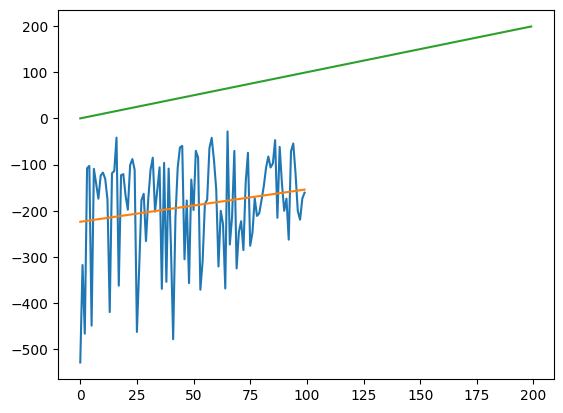

In [5]:
print(agent.policy.epsilon)
agent.plot()

In [6]:
post_policy = Policy(network=QNetwork(), epsilon=FINAL_EPSILON, decay=DECAY)
post_policy.load(f"saved_models/after_{NUMBER_OF_ITERATIONS}-itr_{NUMBER_OF_EPISODES_PER_ITERATION}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{NEURAL_NETWORK_BATCH_SIZE}-bsz")

post_memory = Memory(max_size=MEMORY_SIZE)
post_agent = Agent(policy=post_policy, memory=post_memory)

env = gym.make("LunarLander-v2", render_mode="human")
post_agent.run(env)
env.close()

Using cuda device

